In [12]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import tensorflow.lite as tflite
import numpy as np
tf.__version__

'2.9.1'

In [45]:
# Load test image
x_dino = np.array(load_img("dino.jpg", target_size=(150,150)), dtype=np.float32) / 255
x_dragon = np.array(load_img("dragon.jpg", target_size=(150,150)), dtype=np.float32) / 255
X = np.array([x_dino, x_dragon])
print(X.shape)
classes = ['dino', 'dragon']

(2, 150, 150, 3)


In [31]:
# Load Keras model
model = keras.models.load_model("dino_dragon_v1.h5")
model.predict(tf.convert_to_tensor(X))

1/1 [==============================] - 0s 109ms/step


array([[0.14251374],
       [0.99472994]], dtype=float32)

In [32]:
# Convert Keras model to TF Lite
keras_to_tflite_converter = tflite.TFLiteConverter.from_keras_model(model)
tflite_model = keras_to_tflite_converter.convert()

# Save th TF Lite model to file
with open("dino_dragon_v1.tflite","wb") as tflite_out:
    tflite_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmp9orzxw1i/assets


INFO:tensorflow:Assets written to: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmp9orzxw1i/assets
2022-11-19 16:27:27.820036: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-19 16:27:27.820067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-19 16:27:27.820243: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmp9orzxw1i
2022-11-19 16:27:27.822717: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-11-19 16:27:27.822743: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmp9orzxw1i
2022-11-19 16:27:27.831359: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-11-19 16:27:28.080973: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [33]:
# Open the TF Lite model
tflite_interpreter = tflite.Interpreter("dino_dragon_v1.tflite")
tflite_interpreter.allocate_tensors()
print("tflite input details: ", tflite_interpreter.get_input_details())
print("tflite output details: ", tflite_interpreter.get_output_details())
input_index = tflite_interpreter.get_input_details()[0]["index"]
output_index = tflite_interpreter.get_output_details()[0]["index"]

tflite input details:  [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1, 150, 150,   3], dtype=int32), 'shape_signature': array([ -1, 150, 150,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
tflite output details:  [{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [55]:
# Set input to the TF Lite model
tflite_interpreter.set_tensor(input_index, [X[0]])

In [56]:
# Predict
tflite_interpreter.invoke()

In [57]:
# Get prediction output
pred = tflite_interpreter.get_tensor(output_index)
print(np.round(pred[0][0]).astype(np.uint8))
print(classes[np.round(pred[0][0]).astype(np.uint8)])

0
dino


# TF Lite prediction without TF/Keras dependencies

In [6]:
from PIL import Image
import tensorflow.lite as tflite
import requests
from io import BytesIO
import numpy as np

In [7]:
classes = ['dino', 'dragon']

In [8]:
def preprocess_input(x):
    x /= 255
    return x

def image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150,150), Image.Resampling.NEAREST)
    return img

def image_from_file(filepath):
    with Image.open(filepath) as img:
        img = img.resize((150,150), Image.Resampling.NEAREST)
    return img

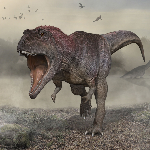

In [9]:
img_url = image_from_url("https://i.natgeofe.com/n/9b87dda3-9946-4a1c-a97f-c21f73ced888/Meraxes-CREDIT-Carlos-Papolio_square.jpg")
img_dino = image_from_file("dino.jpg")
img_dragon = image_from_file("dragon.jpg")
img_url

In [10]:
x_url = np.array(img_url, dtype=np.float32)
x_dino = np.array(img_dino, dtype=np.float32)
x_dragon = np.array(img_dragon, dtype=np.float32)

X = np.array([x_url, x_dino, x_dragon])
X = preprocess_input(X)
X.shape[0]

3

In [11]:
# Open the TF Lite model
tflite_interpreter = tflite.Interpreter("dino_dragon_v1.tflite")
input_index = tflite_interpreter.get_input_details()[0]["index"]
output_index = tflite_interpreter.get_output_details()[0]["index"]
tflite_interpreter.resize_tensor_input(input_index, [X.shape[0], 150, 150, 3])
tflite_interpreter.allocate_tensors()
# Set input to the TF Lite model
tflite_interpreter.set_tensor(input_index, X)
# Predict
tflite_interpreter.invoke()
# Get prediction output
pred = tflite_interpreter.get_tensor(output_index)
print(pred)
print([classes[np.round(prediction[0]).astype(np.uint8)] for prediction in pred])

[[0.51182234]
 [0.14251362]
 [0.99472994]]
['dragon', 'dino', 'dragon']


INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


# Testing

In [13]:
import requests

# Actual HW09

In [14]:
'''
Download the model from here:

https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5
'''
!curl -LO https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 85.6M  100 85.6M    0     0  7785k      0  0:00:11  0:00:11 --:--:-- 7257k


In [15]:
from tensorflow import keras
import tensorflow.lite as tflite
'''
Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the converted model?

    21 Mb
    43 Mb
    80 Mb
    164 Mb
'''
model = keras.models.load_model("dino_dragon_10_0.899.h5")
# Convert Keras model to TF Lite
keras_to_tflite_converter = tflite.TFLiteConverter.from_keras_model(model)
tflite_model = keras_to_tflite_converter.convert()

# Save th TF Lite model to file
with open("dino_dragon_v1.tflite","wb") as tflite_out:
    tflite_out.write(tflite_model)

!ls -hal
# A: 43MB

2022-11-21 22:57:55.887647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmpitqer2zx/assets


INFO:tensorflow:Assets written to: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmpitqer2zx/assets
2022-11-21 22:58:01.926759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-21 22:58:01.926790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-21 22:58:01.935244: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmpitqer2zx
2022-11-21 22:58:01.942122: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-11-21 22:58:01.942190: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/tmpitqer2zx
2022-11-21 22:58:01.959669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-21 22:58:01.973007: I tensorflow/cc/saved_model/load

total 438680
drwxr-xr-x  14 dg  staff   448B Nov 21 22:56 .
drwxr-xr-x  17 dg  staff   544B Nov 19 20:29 ..
drwxr-xr-x   3 dg  staff    96B Nov 18 23:31 .ipynb_checkpoints
-rw-r--r--   1 dg  staff   358B Nov 20 16:23 Dockerfile
-rw-r--r--   1 dg  staff    73K Nov 21 22:56 HW09.ipynb
drwxr-xr-x   5 dg  staff   160B Nov 19 21:44 __pycache__
-rw-r--r--   1 dg  staff   182B Nov 20 17:43 aws_ecr
-rw-r--r--   1 dg  staff    64K Nov 19 16:19 dino.jpg
-rw-r--r--   1 dg  staff    86M Nov 21 22:55 dino_dragon_10_0.899.h5
-rw-r--r--   1 dg  staff    86M Nov 19 00:06 dino_dragon_v1.h5
-rw-r--r--   1 dg  staff    43M Nov 21 22:58 dino_dragon_v1.tflite
-rw-r--r--   1 dg  staff    55K Nov 19 16:19 dragon.jpg
-rw-r--r--   1 dg  staff   2.2K Nov 20 16:28 lambda_function.py
drwxr-xr-x   4 dg  staff   128B Nov 19 22:02 tflite_build


In [16]:
'''
Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

    3
    7
    13
    24
'''
# Open the TF Lite model
tflite_interpreter = tflite.Interpreter("dino_dragon_v1.tflite")
input_index = tflite_interpreter.get_input_details()[0]["index"]
output_index = tflite_interpreter.get_output_details()[0]["index"]
print(output_index)
#A: 13

13


/var/folders/g6/svjv8tvx4xjbr97g7l2krybh0000gn/T/ipykernel_69650/3813737804.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


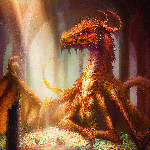

In [19]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

hw_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg"
img = download_image(hw_url)
img = prepare_image(img, (150,150))
img

In [23]:
'''
Question 3

Now we need to turn the image into numpy array and pre-process it.

    Tip: Check the previous homework. What was the pre-processing we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

    0.3353411
    0.5529412
    0.7458824
    0.9654902
'''
img_array = np.array(img, dtype=np.float32)
img_array = img_array / 255
print(img_array.shape)
print(img_array[0,0,0])
# A: 0.5529412

(150, 150, 3)
0.5529412


In [25]:
'''
Question 4

Now let's apply this model to this image. What's the output of the model?

    0.17049132
    0.39009996
    0.60146114
    0.82448614
'''
tflite_interpreter.allocate_tensors()
# Set input to the TF Lite model
tflite_interpreter.set_tensor(input_index, [img_array])
# Predict
tflite_interpreter.invoke()
# Get prediction output
pred = tflite_interpreter.get_tensor(output_index)
print(pred)
print([classes[np.round(prediction[0]).astype(np.uint8)] for prediction in pred])
# A: 0.8244865

[[0.8244865]]
['dragon']


In [26]:
'''
Question 5

Download the base image svizor42/zoomcamp-dino-dragon-lambda:v2. You can easily make it by using docker pull command.

So what's the size of this base image?

    139 Mb
    329 Mb
    639 Mb
    929 Mb

You can get this information when running docker images - it'll be in the "SIZE" column.
'''
# A:     639 Mb

'\nQuestion 5\n\nDownload the base image svizor42/zoomcamp-dino-dragon-lambda:v2. You can easily make it by using docker pull command.\n\nSo what\'s the size of this base image?\n\n    139 Mb\n    329 Mb\n    639 Mb\n    929 Mb\n\nYou can get this information when running docker images - it\'ll be in the "SIZE" column.\n'

In [27]:
'''
Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

You don't need to include the model in the image. It's already included. The name of the file with the model is dino-vs-dragon-v2.tflite and it's in the current workdir in the image (see the Dockerfile above for the reference).

Now run the container locally.

Score this image: https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg

What's the output from the model?

    0.12
    0.32
    0.52
    0.72
'''

'''
Helpful commands:
docker build -t zoomcamp-dino-dragon-lambda .
docker run -p 9000:8080 zoomcamp-dino-dragon-lambda
curl -XPOST "http://localhost:9000/2015-03-31/functions/function/invocations" -d '{"url":"https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg"}'
'''

# A: 0.31950676441192627

'\nHelpful commands:\ndocker build -t zoomcamp-dino-dragon-lambda .\ndocker run -p 9000:8080 zoomcamp-dino-dragon-lambda\ncurl -XPOST "http://localhost:9000/2015-03-31/functions/function/invocations" -d \'{"url":"https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg"}\'\n'

In [29]:
'''
Publishing it to AWS

Now you can deploy your model to AWS!

    Publish your image to ECR
    Create a lambda function in AWS, use the ECR image
    Give it more RAM and increase the timeout
    Test it
    Expose the lambda function using API Gateway

This is optional and not graded.
'''

'''
Helpful commands:
Install awscli
aws configure
aws ecr create-repository --repository-name dino-dragon-image

{
    "repository": {
        "repositoryArn": "arn:aws:ecr:eu-central-1:751140740131:repository/dino-dragon-image",
        "registryId": "751140740131",
        "repositoryName": "dino-dragon-image",
        "repositoryUri": "751140740131.dkr.ecr.eu-central-1.amazonaws.com/dino-dragon-image",
        "createdAt": 1668960598.0,
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        },
        "encryptionConfiguration": {
            "encryptionType": "AES256"
        }
    }
}

"repositoryUri" is the important information here.

Login:
$(aws ecr get-login --no-include-email)

Retag docker image
docker tag dino_dragon_lambda:latest 751140740131.dkr.ecr.eu-central-1.amazonaws.com/dino-dragon-image:dino_dragon_lambda

Push docker image to AWS ECR
docker push 751140740131.dkr.ecr.eu-central-1.amazonaws.com/dino-dragon-image:dino_dragon_lambda

'''

'\nHelpful commands:\nInstall awscli\naws configure\naws ecr create-repository --repository-name dino-dragon-image\n\n{\n    "repository": {\n        "repositoryArn": "arn:aws:ecr:eu-central-1:751140740131:repository/dino-dragon-image",\n        "registryId": "751140740131",\n        "repositoryName": "dino-dragon-image",\n        "repositoryUri": "751140740131.dkr.ecr.eu-central-1.amazonaws.com/dino-dragon-image",\n        "createdAt": 1668960598.0,\n        "imageTagMutability": "MUTABLE",\n        "imageScanningConfiguration": {\n            "scanOnPush": false\n        },\n        "encryptionConfiguration": {\n            "encryptionType": "AES256"\n        }\n    }\n}\n\n"repositoryUri" is the important information here.\n\nLogin:\n$(aws ecr get-login --no-include-email)\n\nRetag docker image\ndocker tag dino_dragon_lambda:latest 751140740131.dkr.ecr.eu-central-1.amazonaws.com/dino-dragon-image:dino_dragon_lambda\n\nPush docker image to AWS ECR\ndocker push 751140740131.dkr.ecr.eu

In [30]:
'''
Publishing to Docker hub

This is just for reference, this is how we published our image to Docker hub:

docker build -t zoomcamp-dino-dragon-lambda .
docker tag zoomcamp-dino-dragon-lambda:latest svizor42/zoomcamp-dino-dragon-lambda:v2
docker push svizor42/zoomcamp-dino-dragon-lambda:v2
'''

'\nPublishing to Docker hub\n\nThis is just for reference, this is how we published our image to Docker hub:\n\ndocker build -t zoomcamp-dino-dragon-lambda .\ndocker tag zoomcamp-dino-dragon-lambda:latest svizor42/zoomcamp-dino-dragon-lambda:v2\ndocker push svizor42/zoomcamp-dino-dragon-lambda:v2\n'